In [1]:
import torch 
from torch import nn 
import torchvision 
from torchvision import datasets 
from torchvision import transforms 
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Cifar-10 Dataset

`Hyper Parameters`

In [3]:
EPOCHS          =     60
BATCH_SIZE      =     128
LEARNING_RATE   =     0.01
WEIGHT_DECAY    =     0.001

`Getting Data Ready`

In [4]:
from torchvision import datasets
train_data = datasets.CIFAR10(
    train=True , 
    root='data',
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    train=False,
    root='data',
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class_names = train_data.classes

In [6]:
sample_data,label= train_data[4]
sample_data.shape,class_names[label]#every image is this shape 

(torch.Size([3, 32, 32]), 'automobile')

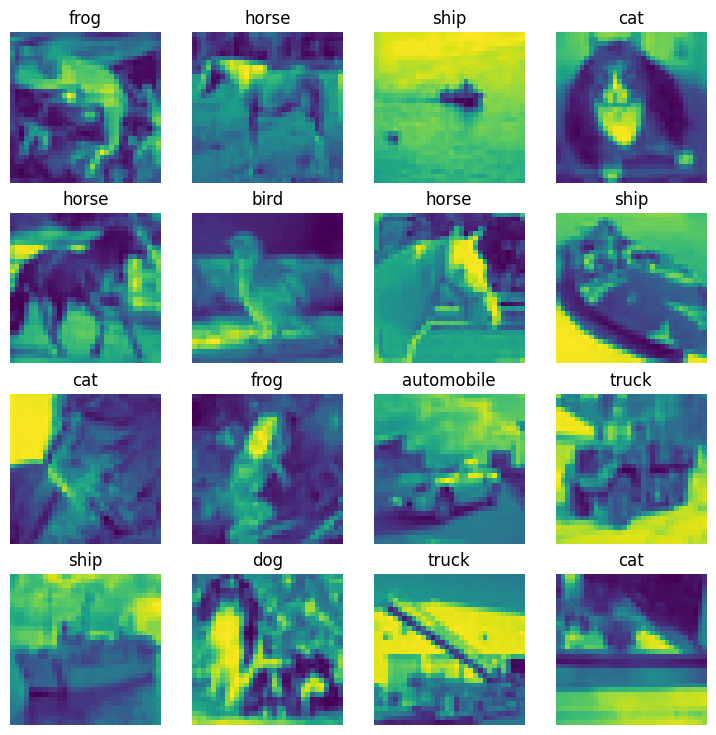

In [7]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows=4
columns=4
for i in range(1,rows*columns+1):
    idx= torch.randint(0,len(train_data),size=[1]).item()
    image,label = train_data[idx]
    image = np.mean(image.numpy(),axis=0) #image to grey scale
    fig.add_subplot(rows,columns,i)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis(False)

`Preparing dataloaders`

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2896d041c50>,
 <torch.utils.data.dataloader.DataLoader at 0x289773d49d0>)

In [9]:
len(train_data),len(test_data),len(train_dataloader),len(test_dataloader)

(50000, 10000, 391, 79)

In [10]:
for batch in train_dataloader:
    inputs, labels = batch
    batch_shape = inputs.shape
    break  # Only need one batch to get the shape
print(f'shape of batch:',batch[0].shape)
print("Shape of a image:", inputs[0].shape)

shape of batch: torch.Size([128, 3, 32, 32])
Shape of a image: torch.Size([3, 32, 32])


Image Size: torch.Size([3, 32, 32])
Label Number: 3
Label Name: cat


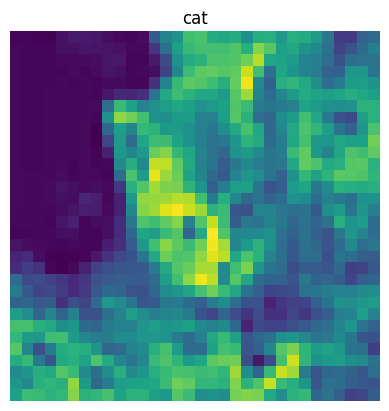

In [11]:
#torch.manual_seed(46)
random_idx= torch.randint(1,len(inputs),size=[1]).item()
img,label = inputs[random_idx],labels[random_idx]
plt.imshow(np.mean(img.numpy(),axis=0))
plt.title(class_names[label])
plt.axis(False)
print(f'Image Size: {img.shape}')
print(f'Label Number: {label}')
print(f'Label Name: {class_names[label]}')

`Model`

In [13]:
class Cifar10_Model(nn.Module):
    def __init__(self,
                 input_nodes: int,
                 hidden_units: int,
                 output_nodes: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_nodes,
                      out_channels=hidden_units,
                      stride=1,
                      padding=1,
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=5,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)       
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      padding=1,
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=5,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)       
        )

        self.classifier= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=6 * 6 * hidden_units,
                      out_features=output_nodes
            )
            
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [19]:
torch.manual_seed(42)
model_0 = Cifar10_Model(input_nodes=3,
                        hidden_units=100,
                        output_nodes=len(class_names)).to(device)

`Sample Input`

In [20]:
inputs = inputs.to(device)
x= model_0(inputs)

`Loss fn & Optimizer`

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=LEARNING_RATE )

`Train Loop`

In [22]:
from tqdm.auto import tqdm
for epoch in tqdm(range(EPOCHS)):
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_0(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0169942378997803
Epoch 2, Loss: 0.8939460515975952
Epoch 3, Loss: 0.7452117204666138
Epoch 4, Loss: 0.5163253545761108
Epoch 5, Loss: 0.620346188545227
Epoch 6, Loss: 0.5467277765274048
Epoch 7, Loss: 0.6988703608512878
Epoch 8, Loss: 0.4589202404022217
Epoch 9, Loss: 0.6409424543380737
Epoch 10, Loss: 0.4029451012611389
Epoch 11, Loss: 0.2635267674922943
Epoch 12, Loss: 0.2577151358127594
Epoch 13, Loss: 0.2519838213920593
Epoch 14, Loss: 0.28888362646102905
Epoch 15, Loss: 0.21965345740318298
Epoch 16, Loss: 0.16566956043243408
Epoch 17, Loss: 0.09460259228944778
Epoch 18, Loss: 0.2418912649154663
Epoch 19, Loss: 0.11202353239059448
Epoch 20, Loss: 0.04615384712815285
Epoch 21, Loss: 0.0959162563085556
Epoch 22, Loss: 0.05189558118581772
Epoch 23, Loss: 0.0440620519220829
Epoch 24, Loss: 0.032643698155879974
Epoch 25, Loss: 0.022657202556729317
Epoch 26, Loss: 0.01626381278038025
Epoch 27, Loss: 0.013324037194252014
Epoch 28, Loss: 0.018859561532735825
Epoch 29, Loss

`Test Loop`

In [25]:
# Test loop
model_0.eval()
with torch.no_grad():
    correct = 0
    
    total = 0
    test_loss = 0
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_0(inputs)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {correct / total}')

Accuracy: 0.8105
